## Machine Learning with Keras on Amazon's fine food review

This notebook will create a convolutional neural network (CNN) off of the fine food review to suggest if the review is a positive (4 or 5 star rating) or a non-positive (1, 2, or 3 star rating).  What we aim here is to use the word2vec embedding implementation in Keras to convert the text into word vectors, and train a CNN with it which will predict, given a review text whethe or not the rating is positive or non-positive.

The steps taken during this notebook are the follows:<br>
- Create a column to indicate if the score was positive or negative, this will be called positive_review
- The text will be turned into vectors using keras implementation of word2vec
- distribution of the vectors will be analyzed to check for outliers and discard them as necessary.
- short vectors will be 0-padded to match in length to the longer vectors.
- CNNs will be trained using different parameters and performance compared amongst the other CNN models

In [18]:
#data importing/wrangling
import pandas as pd

#text processing 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#CNN modeling
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.models import load_model
from keras.layers import Conv2D, Conv1D, MaxPooling1D, MaxPooling2D



#data split
from sklearn.model_selection import train_test_split

#vizualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('ggplot')

from collections import defaultdict
import pickle

input_location = '/Users/momori/Downloads/amazon-fine-food-reviews/reviews_processed.csv'

In [2]:
data = pd.read_csv(input_location)

In [3]:
data.columns

Index([u'Unnamed: 0', u'Id', u'ProductId', u'UserId', u'ProfileName',
       u'HelpfulnessNumerator', u'HelpfulnessDenominator', u'Score', u'Time',
       u'Summary', u'Text', u'HelpfulnessRatio', u'avg_score',
       u'normalized_score'],
      dtype='object')

Create a column 'positive_review' which indicates if the review was positive (4,5 stars) or non-positive (1,2,3 stars)

In [4]:
#add a positive/non-positive rating oolumn
data['positive_review'] = data['Score'] > 3

In [5]:
#create documents and labels to train the model later
docs = data['Text']
labels = data['positive_review']

## Word2Vec embedding

Here we will use the word2vec embedding algorithm implementation by keras.  Since neural networks can only take in numerical values and vectors to train from, the texts will need to be encoded into numerical values.  After each review is encoded, the lengths of the review will be analyzed because the shorter review vedctors needs to be 0-padded to match the longest review vector.  


In [6]:
#Word2Vec embedding

#use the tokenizer API provided by Keras to turn documents into sequences
t = Tokenizer()
t.fit_on_texts(docs)

#encode the documents into integers
encoded_docs = t.texts_to_sequences(docs)
print(encoded_docs[0])

[2, 17, 125, 319, 7, 1, 4940, 523, 103, 52, 204, 3, 17, 117, 28, 41, 5, 30, 7, 29, 183, 1, 38, 629, 48, 26, 4, 2636, 58, 4, 1183, 448, 3, 6, 619, 99, 13, 5266, 8, 1777, 3, 94, 8695, 9, 38, 99, 58, 140]


In [7]:
#create a list of lengths of each of the encoded_docs to find out the longest length, 
#and see if any 0 padding is required
doc_lengths = [len(doc) for doc in encoded_docs]
max_doc_length = max(doc_lengths)

50  percentile of document length: 57.0
60  percentile of document length: 70.0
70  percentile of document length: 88.0
80  percentile of document length: 114.0
90  percentile of document length: 164.0
99  percentile of document length: 398.0


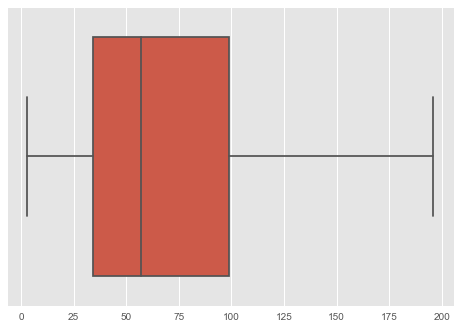

In [8]:
#let's put the lengths into a boxplot to see the distributions of the lengths
np_array = np.array(doc_lengths)

for i in [50,60,70,80,90,99]:
    print i, " percentile of document length:", np.percentile(np_array,i)
    
ax = sns.boxplot(x=doc_lengths, showfliers=False)
plt.show()

we can see from the above plot that the third quantile of document lengths is around 200 words or so.  We can test using this as the max document length and ignoring the outliers.

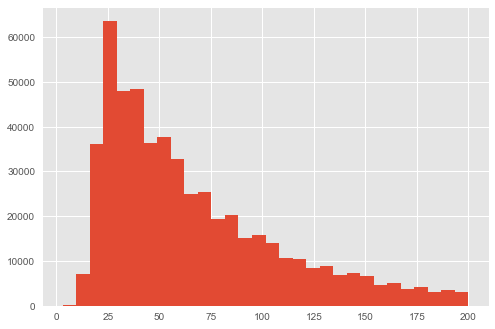

In [9]:
#let's put the lengths into a histogram to see the distributions of the lengths
plt.hist([x for x in doc_lengths if x <= 200], bins=30)
plt.show()



Let's cap the maximum length of the reviews to 200 words, as that will give us a good sense of the overall data without having to zero pad the short reviews to match really long reviews.  

In [10]:
#zero pad the shorter texts
max_length = 200
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')


In [11]:
#find the vocab size from tokenizer
vocab_size = t.word_counts[max(t.word_counts,key=t.word_counts.get)]
print vocab_size

1872496


## Modeling
now that we have the data, we can split this into train/test and create a CNN using Keras. <br>
The CNN will be layered as follows:<br>

- The embedding layer, which is the input layer consisting of the embedded word vectors.
- A Flatten layer, to make the 2-dimensional input into a 1-dimensional output.
- A Dense layer, which will create a fully connected layer with 1 node for the output.
- activation function is sigmoid, because this will give us a binary output, either positive review or non-positive.



In [12]:
#split the data
train_size = 0.7

x_train, x_test, y_train, y_test = train_test_split(
    padded_docs, labels, test_size=train_size, random_state=42)

In [14]:
# #create the CNN
# vect_dimension = 8

# model = Sequential()
# model.add(Embedding(vocab_size, vect_dimension, input_length=max_length))
# model.add(Flatten())
# model.add(Dense(1, activation='sigmoid'))

# #model compilation. add loss function
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# # check model
# print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 8)            14979968  
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1601      
Total params: 14,981,569
Trainable params: 14,981,569
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
#create the CNN
vect_dimension = 32

model = Sequential()
model.add(Embedding(vocab_size, vect_dimension, input_length=max_length))
model.add(Conv1D(32, kernel_size=3, padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

#model compilation. add loss function
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# check model
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 200, 32)           59919872  
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 200, 32)           3104      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 3201      
Total params: 59,926,177
Trainable params: 59,926,177
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
# fit the model
model.fit(x_train, y_train, epochs=2, verbose=1)

# evaluate the model
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print('Accuracy: %f' % (accuracy*100))

Epoch 1/2
170536/170536 [==============================] - 4412s - loss: 0.3039 - acc: 0.8735  
Epoch 2/2
169984/170536 [============================>.] - ETA: 0sAccuracy: 96.052446


In [39]:
#put on test set
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

397312/397918 [============================>.] - ETA: 0sAccuracy: 91.465076


acc after epoch 1 

vect dim 8, filter_size 8: 8623
8, 32: 88, 91, 94, 91


## Hyperparameter tuning

Here, we will try different parameters to tune the CNN and check the performance. 
The first cell will focus on how many dimensions to use and the second cell will focus on different optimizers/loss functions and the result will be plotted in a heatmap to visualize the accuracies

In [47]:
#create multiple CNNs with different hyperparameters

vect_dimensions = [2,4,6,8]
models_accuracy = defaultdict(dict)



for dim in vect_dimensions:
    print 'dim: ', dim
    model = Sequential()
    model.add(Embedding(vocab_size, dim, input_length=max_length))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    #model compilation. add loss function
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    # fit the model
    model.fit(x_train, y_train, epochs=2, verbose=1)

    # evaluate the model
    train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=1)
    print('Training Accuracy: %f' % (train_accuracy*100))

    #put on test set
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
    print('Test Accuracy: %f' % (test_accuracy*100))

    print('\n')
    
    models_accuracy[model]['training_error'] = train_accuracy
    models_accuracy[model]['test_error']=test_accuracy

dim:  2
Epoch 1/2
170535/170535 [==============================] - 280s - loss: 0.3267 - acc: 0.8595   
Epoch 2/2
396928/397917 [============================>.] - ETA: 0sTest Accuracy: 89.581244


dim:  4
Epoch 1/2
170535/170535 [==============================] - 547s - loss: 0.3149 - acc: 0.8657   
Epoch 2/2
396128/397917 [============================>.] - ETA: 0sTest Accuracy: 89.849642


dim:  6
Epoch 1/2
170535/170535 [==============================] - 799s - loss: 0.3077 - acc: 0.8701   
Epoch 2/2
395520/397917 [============================>.] - ETA: 0sTest Accuracy: 90.160511


dim:  8
Epoch 1/2
170535/170535 [==============================] - 1063s - loss: 0.3040 - acc: 0.8717  
Epoch 2/2
397312/397917 [============================>.] - ETA: 0sTest Accuracy: 90.017265




In [54]:
#save the mdoels which was just created
post_name = 1
for k,v in models_accuracy.iteritems():
    out_name = 'keras_model_'+str(post_name)
    k.save(out_name)
    post_name+=1
    


In [56]:
#chcek for the model files
!ls

Modeling.ipynb         keras_model_1          keras_model_4
Proposal.md            keras_model_2          my_model.h5
data_preparation.ipynb keras_model_3


In [66]:
optimizers = ['adam', 'sgd', 'Adagrad', 'Adadelta']
losses = ['mean_squared_error', 'cosine_proximity', 'binary_crossentropy']
metrics=['acc']

models_accuracy = defaultdict(dict)

for optimizer in optimizers:
    for loss in losses:
        print 'optimizer: ', optimizer
        print 'loss: ', loss, '\n'
        model = Sequential()
        model.add(Embedding(vocab_size, 2, input_length=max_length))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        #model compilation. add loss function
        model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

        # fit the model
        model.fit(x_train, y_train, epochs=2, verbose=1)

        # evaluate the model
        train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=1)
        print('\n Training Accuracy: %f' % (train_accuracy*100))

        #put on test set
        test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
        print('\n Test Accuracy: %f' % (test_accuracy*100))

        print('\n')

        #models_accuracy[model]['training_error'] = train_accuracy
        #models_accuracy[model]['test_error']=test_accuracy
        models_accuracy[optimizer][loss] = defaultdict(dict)
        models_accuracy[optimizer][loss]['train_acc']=train_accuracy
        models_accuracy[optimizer][loss]['test_acc']=test_accuracy

        
        print('----------------------------------------')

optimizer:  adam
loss:  mean_squared_error 

Epoch 1/2
170535/170535 [==============================] - 243s - loss: 0.1019 - acc: 0.8621   
Epoch 2/2
167328/170535 [============================>.] - ETA: 0s
 Training Accuracy: 92.103087
397120/397917 [============================>.] - ETA: 0s
 Test Accuracy: 90.006207


----------------------------------------
optimizer:  adam
loss:  cosine_proximity 

Epoch 1/2
170535/170535 [==============================] - 231s - loss: -0.7797 - acc: 0.7791   
Epoch 2/2
169632/170535 [============================>.] - ETA: 0s
 Training Accuracy: 77.970505
396224/397917 [============================>.] - ETA: 0s
 Test Accuracy: 78.108751


----------------------------------------
optimizer:  adam
loss:  binary_crossentropy 

Epoch 1/2
170535/170535 [==============================] - 231s - loss: 0.3266 - acc: 0.8599   
Epoch 2/2
170016/170535 [============================>.] - ETA: 0s
 Training Accuracy: 91.474477
397792/397917 [===================

In [68]:
with open('hyper_parameter_tuning.pickle', 'wb') as handle:
    pickle.dump(models_accuracy, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('hyper_parameter_tuning.pickle', 'rb') as handle:
    b = pickle.load(handle)

print models_accuracy == b

True
